# Install modules and load data

In [67]:
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [68]:
#load data from csv

In [69]:
household_path = "my_stata_file.csv"

In [70]:
household_data = pd.read_csv(household_path)

In [71]:
household_data.head()

,Unnamed: 0,hhid,year,region,work10t12,work13t15,work16t18,uct,femaleh,satth,...,m19t60,f61,m61,quint,rural,treatement,pretreatment,posttreatment,treated,ptreat
0,0,1.201060e+11,2005,Sumatra,0.0,0.0,0.0,0,Male,No education completed,...,0.000000,0.166667,0.166667,Quintile 1 (poorest),Rural,1.0,1.0,0.0,1.0,0.548135
1,1,1.201060e+11,2006,Sumatra,0.0,0.0,0.0,1,Male,Primary,...,0.333333,0.000000,0.000000,Quintile 1 (poorest),Rural,1.0,0.0,1.0,1.0,0.490203
2,2,1.201060e+11,2005,Sumatra,0.0,0.0,0.0,0,Male,No education completed,...,0.166667,0.166667,0.166667,Quintile 1 (poorest),Rural,1.0,1.0,0.0,1.0,0.485999
3,3,1.201060e+11,2006,Sumatra,0.0,0.0,0.0,1,Male,No education completed,...,0.166667,0.333333,0.166667,Quintile 1 (poorest),Rural,1.0,0.0,1.0,1.0,0.507705
4,4,1.201060e+11,2005,Sumatra,0.0,0.0,1.0,0,Female,No education completed,...,0.125000,0.000000,0.000000,Quintile 1 (poorest),Rural,1.0,1.0,0.0,1.0,0.605794


In [72]:
household_data.shape

(12000, 30)

In [73]:
list(household_data.columns)

['Unnamed: 0',
 'hhid',
 'year',
 'region',
 'work10t12',
 'work13t15',
 'work16t18',
 'uct',
 'femaleh',
 'satth',
 'hhsize',
 'f0t6',
 'm0t6',
 'f7t12',
 'm7t12',
 'f13t15',
 'f16t18',
 'f19t60',
 'm13t15',
 'm16t18',
 'm19t60',
 'f61',
 'm61',
 'quint',
 'rural',
 'treatement',
 'pretreatment',
 'posttreatment',
 'treated',
 'ptreat']

In [74]:
#Brief exploration of the data

In [75]:
#hhid refers to the unique, anonymised household id that was created for the study to track household across 2005 and 2006

#region refers to area within Indonesia

#work10t12, work13t15, work16t18 refers to the proportion of household (from 0 to 1) that are engaged in paid labour in the labour force

#uct refers to whether or not a household received an Uncoditional Cash Transfer that year

#femaleh refers to the gender of household head- female led households are considered to be at greater risk of poverty
#satth refers to the highest level of education attained by household head these are:
#No education completed, primary school, junior secondary, senior secondary and higher education

#hhsize refers to the number of household members
#Quintile refers to the income quintile of household, compared to other households in the same region (there is significant inter-regional variation of incomes within Indonesia)

# Data cleaning and pre-processing

In [76]:
#Drop all observations for households in the treated group
household_data.drop(household_data[household_data["treated"]==1].index, inplace=True)

In [77]:
#Turn variable femaleh relating to female head of household into a dummy variable
household_data['femaleh'] = household_data['femaleh'].map({'Female': 1, 'Male': 0})

In [78]:
household_data.head()

,Unnamed: 0,hhid,year,region,work10t12,work13t15,work16t18,uct,femaleh,satth,...,m19t60,f61,m61,quint,rural,treatement,pretreatment,posttreatment,treated,ptreat
24,24,1.201160e+11,2005,Sumatra,0.0,0.0,0.0,0,0,Primary,...,0.200000,0.0,0.0,Quintile 1 (poorest),Rural,0.0,1.0,0.0,0.0,0.275653
25,25,1.201160e+11,2006,Sumatra,0.0,0.0,0.0,0,0,Primary,...,0.166667,0.0,0.0,Quintile 1 (poorest),Rural,0.0,0.0,1.0,0.0,0.336463
32,32,1.201160e+11,2005,Sumatra,0.0,0.0,0.0,0,0,Primary,...,0.142857,0.0,0.0,Quintile 1 (poorest),Rural,0.0,1.0,0.0,0.0,0.348078
33,33,1.201160e+11,2006,Sumatra,0.0,0.5,0.0,0,0,Primary,...,0.250000,0.0,0.0,Quintile 4,Rural,0.0,0.0,1.0,0.0,0.181095
34,34,1.201160e+11,2005,Sumatra,0.0,0.0,1.0,0,0,Primary,...,0.166667,0.0,0.0,Quintile 1 (poorest),Rural,0.0,1.0,0.0,0.0,0.448528


In [79]:
#We are now going to convert educational attainment of household head (satth) into into a series of dummy variables, to more accurately reflect the different bias in any logistic regression
#First, let's get a list of education types 
household_data.satth.unique()

array(['Primary', 'Junior secondary', 'Senior secondary',
       'No education completed', 'Higher'], dtype=object)

In [80]:
#based on the above we can see there are five different categories for education, which means we need four dummy variables
#creating five dummy variables would lead to a dummy variable trap and introduce a situation of perfect multi-collinearity, which is bad
#'No education completed' will be the default with no intercept
household_data['No education'] = np.where(household_data['satth']=='No education completed', 1, 0)
household_data['Primary'] = np.where(household_data['satth']=='Primary', 1, 0)
household_data['Junior secondary'] = np.where(household_data['satth']=='Junior secondary', 1, 0)
household_data['Senior secondary'] = np.where(household_data['satth']=='Senior secondary', 1, 0)
household_data['Higher'] = np.where(household_data['satth']=='Higher', 1, 0)



In [81]:
#Turn variable rural, which records whether a household rural or urban into a dummy variable
household_data['rural'] = household_data['rural'].map({'Rural': 1, 'Urban': 0})

In [82]:
#We are now going to convert income quintiles into into a series of dummy variables, to more accurately reflect the different bias in any logistic regression
#First, let's get a list of the income quintiles
household_data.quint.unique()

array(['Quintile 1 (poorest)', 'Quintile 4', 'Quintile 2',
       'Quintile 5 (richest)', 'Quintile 3'], dtype=object)

In [83]:
#Similar to education attainment, we will create n-1 dummy variables for income quintiles
household_data['Quintile 1'] = np.where(household_data['quint']=='Quintile 1 (poorest)', 1, 0)
household_data['Quintile 2'] = np.where(household_data['quint']=='Quintile 2', 1, 0)
household_data['Quintile 3'] = np.where(household_data['quint']=='Quintile 3', 1, 0)
household_data['Quintile 4'] = np.where(household_data['quint']=='Quintile 4', 1, 0)
household_data['Quintile 5'] = np.where(household_data['quint']=='Quintile 5 (richest)', 1, 0)

In [84]:
#In a similar fashion, we will now convert the various Indonesion provinces in variable Region into a series of dummy variables
household_data.region.unique()

array(['Sumatra', 'Java and Bali', 'Other islands', 'Kalimantan',
       'Sulawesi'], dtype=object)

In [85]:
#Create a series of n-1 dummy variables. 
#We will leave 'Other islands' as the default bias, with no specific dummy varaible of its own.
household_data['Other islands'] = np.where(household_data['region']=='Other islands', 1, 0)
household_data['Sumatra'] = np.where(household_data['region']=='Sumatra', 1, 0)
household_data['Java and Bali'] = np.where(household_data['region']=='Java and Bali', 1, 0)
household_data['Kalimantan'] = np.where(household_data['region']=='Kalimantan', 1, 0)
household_data['Sulawesi'] = np.where(household_data['region']=='Sulawesi', 1, 0)

In [86]:
#Drop unneccessary columns- either because we hae converted into multiple dummy variables, or because they are now redeundant
household_data=household_data.drop(['uct', 'Unnamed: 0', 'treatement', 'pretreatment', 'treated', 'posttreatment', 'ptreat'], axis = 1) 

In [87]:
#let's perform a quick check on 'work10t12' and see how many households are involved- potentially delete

In [88]:
seriesObj = household_data.apply(lambda x: True if x['work10t12'] > 0 else False , axis=1)
numOfRows = len(seriesObj[seriesObj == True].index)
print('Number of observations in dataframe in which children aged 10-12 are involved in workforce : ', numOfRows)

Number of observations in dataframe in which children aged 10-12 are involved in workforce :  16


In [89]:
#Decide to keep observations of 'work10t12'
#At the moment, the outcomes column 'work13t15' only records the proportion of an age group involved in labour force. 
#We want to convert this into a measure of proportion of total household.
household_data['%work10t12'] = household_data['work10t12']*(household_data['f7t12'] + household_data['m7t12'])

In [90]:
#Perform same routine on work13t15
household_data['%work13t15'] = household_data['work13t15']*(household_data['f13t15'] + household_data['m13t15'])

In [91]:
#Do the same for the 'work16t18' variable
household_data['%work16t18'] = household_data['work16t18']*(household_data['f16t18'] + household_data['m16t18'])

In [92]:
household_data['%work10t18'] = household_data['%work10t12']+household_data['%work16t18'] + household_data['%work13t15']

In [93]:
#Drop further unneccessary columns
household_data=household_data.drop(['work10t12', 'work13t15', 'work16t18'], axis = 1) 

In [94]:
household_data['Childlabour'] = np.where(household_data['%work10t18']>0, 1, 0)

In [95]:
household_data.head()

,hhid,year,region,femaleh,satth,hhsize,f0t6,m0t6,f7t12,m7t12,...,Other islands,Sumatra,Java and Bali,Kalimantan,Sulawesi,%work10t12,%work13t15,%work16t18,%work10t18,Childlabour
24,1.201160e+11,2005,Sumatra,0,Primary,10,0.0,0.0,0.000000,0.000000,...,0,1,0,0,0,0.0,0.00,0.000000,0.000000,0
25,1.201160e+11,2006,Sumatra,0,Primary,6,0.0,0.0,0.000000,0.000000,...,0,1,0,0,0,0.0,0.00,0.000000,0.000000,0
32,1.201160e+11,2005,Sumatra,0,Primary,7,0.0,0.0,0.142857,0.000000,...,0,1,0,0,0,0.0,0.00,0.000000,0.000000,0
33,1.201160e+11,2006,Sumatra,0,Primary,4,0.0,0.0,0.000000,0.000000,...,0,1,0,0,0,0.0,0.25,0.000000,0.250000,1
34,1.201160e+11,2005,Sumatra,0,Primary,6,0.0,0.0,0.000000,0.333333,...,0,1,0,0,0,0.0,0.00,0.166667,0.166667,1


In [96]:
#Separate the observations from 2005 and 2006 into separate dataframes- 
#We can then join the two years on the unique value hhid, taking from the 2006 dataframe our key target variable, 
# that is whether there was child labour in 2006 in that household.
data_2005 = household_data[household_data.year == 2005]
data_2006 = household_data[household_data.year == 2006]

In [97]:
data_2005.head()

,hhid,year,region,femaleh,satth,hhsize,f0t6,m0t6,f7t12,m7t12,...,Other islands,Sumatra,Java and Bali,Kalimantan,Sulawesi,%work10t12,%work13t15,%work16t18,%work10t18,Childlabour
24,1.201160e+11,2005,Sumatra,0,Primary,10,0.0,0.0,0.000000,0.000000,...,0,1,0,0,0,0.0,0.0,0.000000,0.000000,0
32,1.201160e+11,2005,Sumatra,0,Primary,7,0.0,0.0,0.142857,0.000000,...,0,1,0,0,0,0.0,0.0,0.000000,0.000000,0
34,1.201160e+11,2005,Sumatra,0,Primary,6,0.0,0.0,0.000000,0.333333,...,0,1,0,0,0,0.0,0.0,0.166667,0.166667,1
36,1.202050e+11,2005,Sumatra,0,Primary,5,0.0,0.0,0.000000,0.000000,...,0,1,0,0,0,0.0,0.0,0.200000,0.200000,1
38,1.202050e+11,2005,Sumatra,0,Primary,3,0.0,0.0,0.000000,0.000000,...,0,1,0,0,0,0.0,0.0,0.000000,0.000000,0


In [98]:
#Let's merge the two dataframes, but we will only take the outcome columns from 2006
cleaned_data = pd.merge(data_2005,data_2006[['hhid', 'Childlabour']],on='hhid', how='left')

In [99]:
cleaned_data.shape

(4353, 41)

In [100]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(cleaned_data.head())

,hhid,year,region,femaleh,satth,hhsize,f0t6,m0t6,f7t12,m7t12,f13t15,f16t18,f19t60,m13t15,m16t18,m19t60,f61,m61,quint,rural,No education,Primary,Junior secondary,Senior secondary,Higher,Quintile 1,Quintile 2,Quintile 3,Quintile 4,Quintile 5,Other islands,Sumatra,Java and Bali,Kalimantan,Sulawesi,%work10t12,%work13t15,%work16t18,%work10t18,Childlabour_x,Childlabour_y
0,1.201160e+11,2005,Sumatra,0,Primary,10,0.0,0.0,0.000000,0.000000,0.100000,0.100000,0.500000,0.0,0.1,0.200000,0.0,0.0,Quintile 1 (poorest),1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0.0,0.0,0.000000,0.000000,0,0
1,1.201160e+11,2005,Sumatra,0,Primary,7,0.0,0.0,0.142857,0.000000,0.000000,0.142857,0.571429,0.0,0.0,0.142857,0.0,0.0,Quintile 1 (poorest),1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0.0,0.0,0.000000,0.000000,0,1
2,1.201160e+11,2005,Sumatra,0,Primary,6,0.0,0.0,0.000000,0.333333,0.166667,0.166667,0.166667,0.0,0.0,0.166667,0.0,0.0,Quintile 1 (poorest),1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0.0,0.0,0.166667,0.166667,1,0
3,1.202050e+11,2005,Sumatra,0,Primary,5,0.0,0.0,0.000000,0.000000,0.000000,0.200000,0.200000,0.0,0.2,0.400000,0.0,0.0,Quintile 2,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0.0,0.0,0.200000,0.200000,1,1
4,1.202050e+11,2005,Sumatra,0,Primary,3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.0,0.666667,0.0,0.0,Quintile 5 (richest),0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0.0,0.0,0.000000,0.000000,0,0


In [101]:
cleaned_data = cleaned_data.rename(columns={'Childlabour_x': 'Childlabour_05', 'Childlabour_y': 'Childlabour_06'})

In [102]:
#Now that we have used year to split our data and then merge it into a single row for each household, 
#we can drop it as a variable

In [103]:
cleaned_data=cleaned_data.drop(["year"], axis=1)

# Exploratory Data Analysis

In [104]:
#First let's get a look at the occurences of our target variable "Childlabour_y", 
#which is the occurence of child labour within a household in 2006
cleaned_data['Childlabour_06'].value_counts()

0    4094
1     259
Name: Childlabour_06, dtype: int64

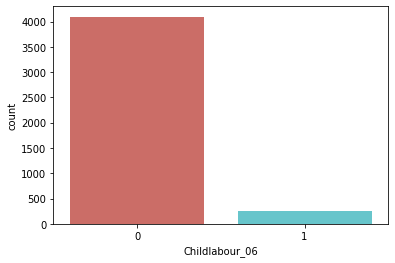

In [105]:
sns.countplot(x="Childlabour_06", data=cleaned_data, palette='hls')
plt.show()

In [106]:
count_no_work = len(cleaned_data[cleaned_data["Childlabour_06"]==0])
count_work = len(cleaned_data[cleaned_data["Childlabour_06"]==1])
pct_of_no_work = count_no_work/(count_no_work+count_work)
print("percentage of households without child labour is", pct_of_no_work*100)
pct_of_work = count_work/(count_no_work+count_work)
print("percentage of households with labour is", pct_of_work*100)

percentage of households without child labour is 94.05008040431886
percentage of households with labour is 5.9499195956811395


In [107]:
#Hmmm, we seem to have a very unbalanced dataset here. Probably should have checked that before I decided on this topic.
#We will deal with this in the modelling, using SMOTE.

In [108]:
#Next, let's break down the data by our outcome variable "Childlabour_06", and see if there is any diferences between households
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(cleaned_data.groupby("Childlabour_06").mean())

,hhid,femaleh,hhsize,f0t6,m0t6,f7t12,m7t12,f13t15,f16t18,f19t60,m13t15,m16t18,m19t60,f61,m61,rural,No education,Primary,Junior secondary,Senior secondary,Higher,Quintile 1,Quintile 2,Quintile 3,Quintile 4,Quintile 5,Other islands,Sumatra,Java and Bali,Kalimantan,Sulawesi,%work10t12,%work13t15,%work16t18,%work10t18,Childlabour_05
Childlabour_06,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.834389e+11,0.097215,4.008549,0.056587,0.060691,0.061651,0.064718,0.023325,0.023116,0.304007,0.022509,0.020775,0.290588,0.047240,0.040535,0.523205,0.242794,0.325110,0.141915,0.223009,0.067171,0.125794,0.174890,0.202736,0.235711,0.260870,0.071568,0.203468,0.562042,0.089888,0.073034,0.000334,0.002041,0.009074,0.011449,0.050073
1,4.250288e+11,0.096525,5.034749,0.042039,0.039635,0.080732,0.068507,0.055254,0.050418,0.252939,0.064658,0.073946,0.250106,0.016518,0.022670,0.694981,0.316602,0.436293,0.127413,0.081081,0.038610,0.262548,0.220077,0.181467,0.150579,0.185328,0.092664,0.212355,0.432432,0.146718,0.115830,0.004413,0.036275,0.076097,0.116785,0.455598


In [109]:
#A few observations:

#slightly larger household sizes (average of 5 vs 4 household members) for child labour households.
#were more likely to be rural (69% for child labour households, 52% of non-child labour households)
#more likely to have lower education levels (no education or primary education)
#were more likely to fall into the lower income quartiles (quitnile 1 or 2)
#more likely to occur in poorer regions such as Kalimantan and Sulawesi, as opposed to wealthier regions such as Java or Bali
#unsurprsingly, households that already had child labour in 2005 were more likely to have child labour in 2006.

Text(0, 0.5, 'Proportion of households with child labour')

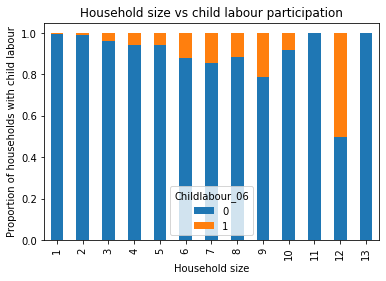

In [110]:
table=pd.crosstab(cleaned_data.hhsize, cleaned_data.Childlabour_06)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Household size vs child labour participation')
plt.xlabel('Household size')
plt.ylabel('Proportion of households with child labour')

In [111]:
#For context, let's see the breakdown of household size.
cleaned_data[['hhsize', 'hhid']].groupby('hhsize').count()

,hhid
hhsize,
1,183
2,504
3,973
4,1167
5,777
6,414
7,196
8,87
9,33


Text(0, 0.5, 'Proportion of households with child labour')

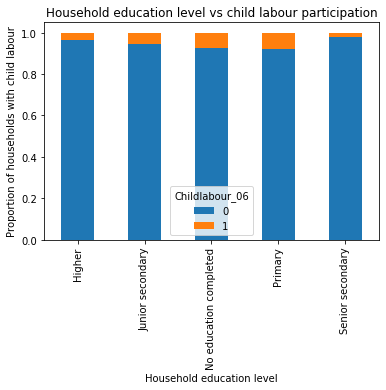

In [112]:
table=pd.crosstab(cleaned_data.satth, cleaned_data.Childlabour_06)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Household education level vs child labour participation')
plt.xlabel('Household education level')
plt.ylabel('Proportion of households with child labour')

Text(0, 0.5, 'Proportion of households with child labour')

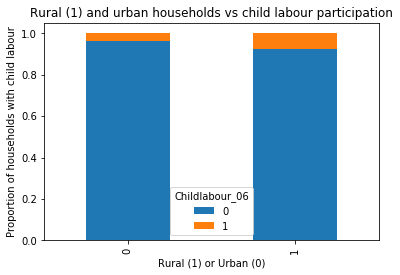

In [113]:
table=pd.crosstab(cleaned_data.rural, cleaned_data.Childlabour_06)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Rural (1) and urban households vs child labour participation')
plt.xlabel('Rural (1) or Urban (0)')
plt.ylabel('Proportion of households with child labour')

Text(0, 0.5, 'Proportion of households with child labour')

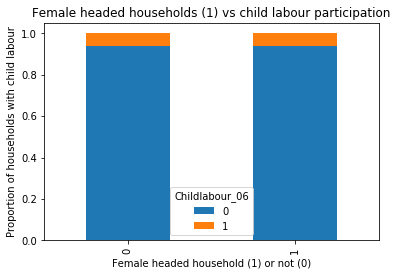

In [114]:
table=pd.crosstab(cleaned_data.femaleh, cleaned_data.Childlabour_06)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Female headed households (1) vs child labour participation')
plt.xlabel('Female headed household (1) or not (0)')
plt.ylabel('Proportion of households with child labour')

In [115]:
cleaned_data=cleaned_data.drop(["hhid", "region", "quint", "satth"], axis=1)

In [116]:
# Now based on %work10t18_y and Childlabour_y, we have our final outcome variable, 
# which we can train our machine learning model to classify and predict. 
#At this point we might normally seek to apply some further scaling/normalisation or other transformation to our data. 
#However, our data is largely scaled to between 0 and 1 already.

# Let's export this as a csv for the next step
cleaned_data.to_csv('cleaned_data.csv') 